In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, normaltest
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.figure_factory as ff

# 1. Wybór tematu i danych

Do tworzenia projektu zdecydowałam się na język Python, kod umieszczany i testowany w notatniku Keggle. Wybrany przeze mnie zbiór danych to "Prima Indian Diabetes Database".
Zbiór ten posiada następujące kolumny:

* Pregnancies - ilość ciąż przebytych przez kobietę
* Glucose - koncentracja glukozy w osoczu w 2 godzinowym teście tolerancji glukozy
* BloodPressure - ciśnienie krwi (mm Hg)
* SkinThickness - grubość płata skóry na tricepsie (mm)
* Insulin - insulina w surowicy (2 godzinna) (muU/ml)
* BMI - "Body mass index" (kg/m^2)
* DiabetesPedigreeFunction - funkcja rodowodu cukrzycy (prawdopodobieństwo cukrzycy na podstawie historii rodziny)
* Age - wiek (w latach)
* Outcome - jeśli 1 - stwierdzona cukrzyca, jeśli 0 - nie.

**Cel**: W mojej analizie skupię się na poszczególnych etapach:

* Predykcja ryzyka zachorowania na cukrzycę na podstawie badanych zmiennych
 
* Zależność poziomu insuliny od pozostałych predykatorów

* Fenotypowanie pacjentów (analiza skupień i dalej odniesienie tej analizy do zbadania największej grupy ryzyka).


#### Czym właściwie jest cukrzyca?

Cukrzyca - grupa chorób metabolicznych, charakteryzujących się podwyższonym poziomem cukru we krwi, wynikającym z defektu produkcji lub dziłania insuliny (hormonu regulującego poziom cukru, wydzielanego przez trzustkę). Przewlekła i nieleczona wiąże się z uszkodzeniem i uszkodzeniem działania różnych narządów, w szczególności oczu, nerek czy serca. Istnieje podział cukrzycy na typy:

* Najczęściej występująca - **cukrzyca typu II** - dochodzi do insulinoodporności, przez co trzuska musi produkować większe ilości hormonu przez co dochodzi do przekroczenia zdolności wydzielniczych trzustki. Dochodzi do uszkodzenia tego organu a później zaprzestania produkowania insuliny.
* **Cukrzyca typu I** - proces autoimunologiczny niszczy komórki trzustki produkujące insulinę. Wywołuje to brak insuliny we krwi przy zachowaniu normalnej wrażliwości tkanek.
* **Cukryca ciężarnych** - związana ze zmianami hormonalnymi występującymi podczas ciąży. 

Podstawowym objawem jest podwyższenie stężenia glukozy we krwi (może być wyższa po spożyciu węglowodanów lub nie, w zależności od stadium i typu choroby). Prawidłowy jej poziom to 70–99 mg/dl (3,9-5,5 mmol/l) na czczo oraz poniżej 140 mg/dl (7,8 mmol/l) w 120 minucie testu doustnego obciążenia glukozą. 

https://pl.wikipedia.org/wiki/Cukrzyca#Stężenie_glukozy_we_krwi

##### Odnośnik do Diabetes Pedigree Function:

Znalezione informacje na temat DPF (niekoniecznie użyte w tych danych, niestety nie byłam w stanie znaleźć użytego wzoru) mówią, że jest to funkcja uwzględniająca historię choroby wśród najbliższych krewnych i na tej podstawie przewidująca możliwość nabycia cukrzycy. Używa informacji pochodzących od rodziców, dziadków, rodzeństwa (również tego z jednego rodzica), wujków i cioci a także kuzynów w pierwszej linii. Wzór:

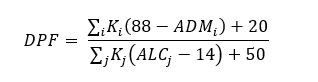

Jest to wzór eksperymentalny wyliczony na podstawie dostępnych danych. 

Oznaczenia:

* *i* - indeks, który iteruje po wszystkich badanych członkach rodziny, którzy w momencie badań byli już chorzy na cukrzycę,
* *j* - iteruje po wszystkich członkach rodziny, którzy w momencie przeprowadzania badań NIE byli chorzy na cukrzycę,
* *Ki* - jest to procent pokrewieństwa:
    * wynosi 0.5, jeśli pokrewieństwo to: rodzic albo rodzeństwo z obu rodziców
    * 0.25, jeśli to brat lub siostra z jednego rodzica, dziadkowie, ciotka albo wujek
    * 0.125, jeśli dalszy ("half aunt/uncle") wujek/ciocia lub najbliższy kuzyn/kuzynka
* *ADMi* - wiek w latach członka rodziny "i", u którego cukrzyca była zdiagnozowana
* *ALCj* - wiek członka rodziny w czasie ostatniego badania, które wykazało brak choroby.

źródło: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2245318/pdf/procascamc00018-0276.pdf

W odniesieniu do danych wejściowych, według tego wzoru żadna inna zmienna nie powinna mieć wpływu na wartość funkcji rodowodu cukrzycy (DPF).

    


# 2. Czyszczenie i analiza danych:

In [ ]:
#wczytanie danych do zmiennej lokalnej "my_data"
my_data = pd.read_csv("../input/pima-indians-diabetes-database/diabetes.csv")
my_data.head()

In [ ]:
D = my_data[(my_data['Outcome'] != 0)]
H = my_data[(my_data['Outcome'] == 0)]

def my_count():
    trace = go.Bar( x = my_data['Outcome'].value_counts().values.tolist(), 
                    y = ['zdrowy','cukrzyk' ], 
                    orientation = 'h', 
                    text = my_data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['green', 'pink'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Liczba osób chorych i zdrowych:')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    
my_count()

Należy zbadać czy wybrany zestaw danych nie posiada braków, tak aby dało się przeprowadzać dalszą analizę:

In [ ]:
my_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = my_data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

Zdefiniowanie wykresu, do odnalezenia brakujących wartości w badanym zbiorze:

In [ ]:
def plot_miss(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Brakujące wartości (ilość i procent)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
    
plot_miss(my_data, 'Outcome')

In [ ]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Zmienne')
plt.title("Mój dataset:")
ax = sns.boxplot(data = my_data, 
  orient = 'h', 
  palette = 'Set2')

Brakujące zmienne powinny zostać zastąpione medianą celu.

In [ ]:
def median_tar(var):   
    temp = my_data[my_data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [ ]:
def distribute_plot(selected_data, size) : 
    tmp1 = D[selected_data]
    tmp2 = H[selected_data]
    
    hist_data = [tmp1, tmp2]
    
    group_labels = ['cukrzyk', 'zdrowy']
    colors = ['#ffcfd9', '#00c400']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size, curve_type='kde')
    
    fig['layout'].update(title = selected_data)

    py.iplot(fig, filename = 'Wykres gęstości')

Tworzymy wykresy dla każdej zmiennej ilościowej:

##### Ciąże:

In [ ]:
distribute_plot('Pregnancies', 0)

In [ ]:
median_tar('Pregnancies')

Widać różnicę w rozkładzie ilości urodzeń przez kobiety chore i zdrowe. Osoby chore częsciej posiadały większą ilość potomstwa. 

##### Glukoza:

In [ ]:
distribute_plot('Glucose', 0)

In [ ]:
median_tar('Glucose')

In [ ]:
my_data.loc[(my_data['Outcome'] == 0 ) & (my_data['Glucose'].isnull()), 'Glucose'] = 107
my_data.loc[(my_data['Outcome'] == 1 ) & (my_data['Glucose'].isnull()), 'Glucose'] = 140

W tym rozkładzie, naturalnie, widzimy więcej przypadków osób chorych z wyższym poziomem glukozy. Jest to zjawisko przewidywalne z racji, że podwyższony poziom glukozy jest bezpośrednią definicją choroby.

##### Ciśnienie krwi:

In [ ]:
distribute_plot('BloodPressure', 0)

Tutaj widzimy nieznaczy wzrost przypadków ciśnienia wyższego u osób z cukrzycą, jest to jednak dość mała różnica.

In [ ]:
median_tar('BloodPressure')

Uzupełnienie danych:

In [ ]:
my_data.loc[(my_data['Outcome'] == 0 ) & (my_data['BloodPressure'].isnull()), 'BloodPressure'] = 70
my_data.loc[(my_data['Outcome'] == 1 ) & (my_data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

Mediana ciśnień osoby zdrowej i chorej niewiele się różni, mimo wszystko jest to zauważalne i ciśnienie jest wyższe dla osoby chorej.

##### Grubość skóry:

In [ ]:
distribute_plot('SkinThickness', 0)

In [ ]:
median_tar('SkinThickness')

Uzupełnienie brakujących danych:

In [ ]:
my_data.loc[(my_data['Outcome'] == 0 ) & (my_data['SkinThickness'].isnull()), 'SkinThickness'] = 27
my_data.loc[(my_data['Outcome'] == 1 ) & (my_data['SkinThickness'].isnull()), 'SkinThickness'] = 32

Tutaj mamy już zauważalną różnicę w grubości skóry osoby chorej a zdrowej (5mm)

##### Insulina:

In [ ]:
distribute_plot('Insulin', 0)

In [ ]:
median_tar('Insulin')

Uzupełnienie danych:

In [ ]:
my_data.loc[(my_data['Outcome'] == 0 ) & (my_data['Insulin'].isnull()), 'Insulin'] = 102.5
my_data.loc[(my_data['Outcome'] == 1 ) & (my_data['Insulin'].isnull()), 'Insulin'] = 169.5

Poziom insuliny jest zdecydowanie wyższy dla cukrzyków. To również wynika z charakterystyki samej choroby.

##### BMI:

In [ ]:
distribute_plot('BMI', 0)

In [ ]:
median_tar('BMI')

Uzupełnienie danych:

In [ ]:
my_data.loc[(my_data['Outcome'] == 0 ) & (my_data['BMI'].isnull()), 'BMI'] = 30.1
my_data.loc[(my_data['Outcome'] == 1 ) & (my_data['BMI'].isnull()), 'BMI'] = 34.3

Liczba BMI jest na wysokim poziomie zarówno dla osób zdrowych jak i chorych, jednak widać że kobiety z cukrzycą mają ten poziom znacznie wyższy. Wzor na BMI to: masa ciała [kg]/ kwadrat wzrostu w metrach) więc przykładowo dla osoby mierzącej 160cm, dla BMI około 30.5 to waga 78kg, natomiast dla 34 to już 87kg a więc prawie 10kg różnicy. Jest to znacząca różnica wagi.  

##### DPF (Diabetes Pedigree Function):

In [ ]:
distribute_plot('DiabetesPedigreeFunction', 0)

In [ ]:
median_tar('DiabetesPedigreeFunction')

Różnica w funkcji rodowodu cukrzycy jest bardzo niewielka dla osób chorych i zdrowych, jednak jest nieco wyższa u cukrzyków.

##### Age:

In [ ]:
distribute_plot('Age', 0)

In [ ]:
median_tar('Age')

Widać, że mediana wieku osób chorych jest wyższa niż zdrowych. Nie musi to być jednak czynnik bezpośredni, ale może być powiązany z ilością posiadanych dzieci lub masą ciała, którą trudniej utrzymać wraz z wiekiem.

In [ ]:
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [ ]:
missing_plot(my_data, 'Outcome')

Wszystkie wartości zostały uzupełnione wartością z mediany.

##### Zad 1. Opracuj podstawowe statystyki dla każdej zmiennej ilościowej:

W wybranym przeze mnie zbiorze każda kolumna posiada zmienne ilościowe. Wszystkie zostaną więc poddane analizie statystycznej. 

In [ ]:
quantity_cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
quantity_stat = my_data[quantity_cols].agg(["count","mean","median","min", "max", "std", "var"])
quantity_stat = quantity_stat.append(my_data[quantity_cols].mode().rename(index={0:"mode"}))
quantity_stat

##### Zad 2. Opracuj tabele licznośći dla każdej zmiennej jakościowej z hipotez:
W moim zbiorze nie posiadam zmiennych jakościowych dlatego też nie jestem w stanie wykonać tego punktu.

##### Macierz korelacji:

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(my_data.corr(), annot=True, ax=ax)
my_data.corr()

Na wykresie najbardziej wyróżniąją się korelacje pomiędzy:

* zmienną *Age* i *Pregnancies* co jest logiczne, z racji, że kobieta starsza ma więcej czasu na urodzenie większej liczby potomstwa,
* zmienną *Glucose* i *Outcome* - onznacza, że wraz ze wzrostem stężenia glukozy we krwi rośnie prawdopodobieństwo cukrzycy. Również jest to logiczne.
* spora korelacja pomiędzy zmienną *BMI* i *SkinThickness* - znaczy, że przy wyższym BMI badana osoba posiadała większą grubość fałdu skórnego na tricepsie. Uważam, że jest to prawdopodobne, z racji, że zwykle większe BMI wiąże sie z otyłością, podobnie jak większa grubość fałdu skórnego. 
* zmienną *Insulin* i *Glucose*. Jest to korelacja logiczna, z racji że podwyższone stężenie cukru ma wpływ na gospodarkę insulinową.
* Jest również widoczna słaba koleracja pomiędzy *BMI* a *BloodPressure*. Także ciekawa obserwacja, której powinnam się przyjrzeć.
* *BMI* i *Outcome* również wykazują wzajemną korelację.

##### Test niezależności przy użyciu testu chi^2 - założenie poziomu istotności alfa = 0.01.

Z racji, że nie mam konretnej hipotezy, ale badam wzajemny wpływ wszystkich zmiennych, to wszystkie powinny być przetestowane:

Pierwszy test dla zmiennej "Pregnancies":

In [ ]:
to_drop = ["Pregnancies"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Test dla "Glucose":

In [ ]:
to_drop = ["Glucose"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Test dla "BloodPressure":

In [ ]:
to_drop = ["BloodPressure"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Test dla "SkinThickness":

In [ ]:
to_drop = ["SkinThickness"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Test dla "Insulin":

In [ ]:
to_drop = ["Insulin"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Test dla "DiabetesPedigreeFunction"

In [ ]:
to_drop = ["DiabetesPedigreeFunction"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

In [ ]:
to_drop = ["Age"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Test dla zmiennej BMI:

In [ ]:
to_drop = ["BMI"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Test dla zmiennej BloodPressure:

In [ ]:
to_drop = ["BloodPressure"]
for col in my_data.columns:
    if col not in to_drop:
        contigency = pd.crosstab(my_data[col], my_data["Outcome"])
        chi,p_value,degrees_of_freedom , expected_freq = chi2_contingency(contigency)
        print(f"Dla {col} test niezależności wyniósł (p): {p_value}")
        if p_value <= 0.01:
            print(f"p jest mniejsze od poziomu istotności, który założyłam, mogę odrzucić hipotezę zerową (zmienne zależne)\n")
        else:
            print(f"p jest większe od poziomu istotności, który założyłam, potwierdzam hipotezę zerową (zmienne niezależne)\n")

Testy niezależności wykazują, że praktycznie wszystkie zmienne są ze sobą wzajemnie skorelowane. Tylko zmienne DiabetesPedigreeFunction i BMI zostały oznaczone jako zmienne niezależne od pozostałych testów. W przypadku DPF jest to racjonalne, ponieważ we wzorze na te zmienna (przytoczony na początku projektu) nie występują żadne zmienne badane. Natomiast w przypadku BMI wydaje mi się to dziwne, z racji, że zależności z innymiz zmiennymi w macierzy korelacji wyglądały na dość istotne.

##### Wykresy ramka - wąsy dla zmiennych ilościowych z hipotez:

In [ ]:
figure, axis = plt.subplots(len(quantity_cols),1,  figsize=(15,30))
for i, cols in enumerate(quantity_cols):
    axis[i].set_title(f"Wykres dla zmiennej ilościowej: {cols}")
    #sns.histplot(data = data, x=my_data["Pregnancies"], hue=cols, ax=axis[i])
    sns.boxplot(data = my_data, x=my_data[cols], ax=axis[i], orient = "h")
figure.tight_layout()
   

Widać, że dla niektórych zmiennych mamy spore wartości odstające, mimo wcześniejszego wyczyszczenia tych danych. Największą różnicę widać na wykresie dla zmiennej "Insulin". Powinnam więc sprawdzić te dane. 

In [ ]:
my_data[my_data["Insulin"]>=250]

Z racji, że ta zmienna ma spore korelacje z innymi zmiennymi, zdecydowałam sie na zastąpienie wartości zmiennej Insulin większych od 250 przez losową wartość w przedziale 10, 250.

In [ ]:
import random
my_data.loc[my_data["Insulin"] >= 250,"Insulin"] = my_data["Insulin"].apply(lambda x: random.randrange(5,250))

In [ ]:
sns.boxplot(data = my_data, x=my_data["Insulin"], orient = "h")

Widać, jak zmienił się rozkład dla tej zmiennej. Zrobię podobnie dla kolejnych zmiennych z mocno odstającymi wartościami.

In [ ]:
my_data[my_data["SkinThickness"]<=15]

In [ ]:
my_data[my_data["SkinThickness"]>=45]

In [ ]:
import random
my_data.loc[((my_data["SkinThickness"] <= 45)&(my_data["SkinThickness"] >= 15)),"SkinThickness"] = my_data["SkinThickness"].apply(lambda x: random.randrange(15,45))

In [ ]:
sns.boxplot(data = my_data, x=my_data["SkinThickness"], orient = "h")

Ostanie sprawdzenie dla DiabetesPedigreeFunction:

In [ ]:
my_data[my_data["DiabetesPedigreeFunction"]<=1.2]

In [ ]:
import random
my_data.loc[my_data["DiabetesPedigreeFunction"] >= 1.2,"DiabetesPedigreeFunction"] = my_data["DiabetesPedigreeFunction"].apply(lambda x: random.randrange(0, 1))

In [ ]:
sns.boxplot(data = my_data, x=my_data["DiabetesPedigreeFunction"], orient = "h")

##### Test normalny dla zmiennych ilościowych:

In [ ]:
fig, axes = plt.subplots(len(quantity_cols), 1, figsize=(10,20))
for i, col in enumerate(quantity_cols):
    axes[i].set_title(f"Rozkład liczności zmiennej {col}")
    sns.histplot(my_data[col], ax=axes[i], kde=True)
plt.tight_layout()

In [ ]:
for i, col in enumerate(quantity_cols):
    print(f"Wartość p testu dla {col} jest równe {normaltest(my_data[col].values).pvalue}\n")

Zmienne Glucose, BloodPressure, BMI i DiabetesPedigreeFunction są przybliżeniem rozkładu normalnego.

##### Wykresy rozrzutu:

Wykonam wykresy rozrzutu dla wszystkich zmiennych i postaram się poszukać zależności pomiędzy nimi.


In [ ]:
g = sns.PairGrid(my_data, hue="Outcome")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

Z powyższych wykresów możemy wywnioskować, że:
* Prawdopodobieństwo zachorowania na cukrzycę wyraźnie wzrasta wraz ze wzrostem poziomu glukozy i insuliny
* Ilość przebytych ciąży również może mieć niewielki wpływ na cukrzycę, jednak może to być również wpływ innych zmiennych.
* BMI może również mieć wpływ na zachorowanie 
* DiabetesPedigreeFunction również wygląda, jakby miała bardzo nieduży wpływ na prawdopodobieństwo cukrzycy

Inne zmienne nie wykazują dużych związków z chorobą. Najmocniejsze zależności to: glukoza, insulina, ciąże i BMI.

Wydaje się, że zmienne SkinThickness i BMI są ze sobą mocno wzajemnie skorelowane. 
Model zależności glukozy oraz insuliny od wyniku może być liniowy. Kierunek jest dodatni, z racji, że wzrost zmiennych powoduje wzrost prawdopodobieństwa choroby.

# 3. Indukcja drzew decyzyjnych

Do sprawdzenia moich danych wykorzystam zmienne BMI, Glucose i Insuline.

##### Dla badania zmiennej Insulin wykorzystam drzewo regresyjne, z racji,że mam tutaj do czynienia z przewidywaniami wartości:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_recall_fscore_support
pd.options.mode.chained_assignment = None


# Potrzebne do regresji dane
reg_hipo_data = my_data[["BMI", "Glucose", "Outcome"]]
reg_hipo_y = my_data["Insulin"]


# Podzial na sety testowe i treningowe
X_train, X_test, y_train, y_test = train_test_split(reg_hipo_data, reg_hipo_y, train_size=0.7, random_state=1)

# Zaladowanie modelu
tree_model = DecisionTreeRegressor(min_samples_leaf=40, max_leaf_nodes=500)

# Trenowanie
tree_model.fit(X_train, y_train)

# Testowanie dokladnosci na danych testowych

preds = tree_model.predict(X_test)
r2score = r2_score(y_test, preds)
print(f"Wspolczynnik zbiezności = {((1-r2score)*100):.2f}% - Im blizej 0% tym model jest dokladniejszy")

In [ ]:
pred_import = tree_model.feature_importances_
std = np.std(pred_import,axis=0)
ind = np.argsort(pred_import)
plt.figure()
plt.title("Waznosc predykatorow")
plt.barh(range(reg_hipo_data.shape[1]), pred_import[ind],
       color="r", xerr=std, align="center")
plt.yticks(range(reg_hipo_data.shape[1]), reg_hipo_data.columns)
plt.ylim([-1, reg_hipo_data.shape[1]])
plt.grid(b=True)
plt.xlim(0, 1)
plt.show()

In [ ]:
plt.figure(figsize=(15,15))
plot_tree(tree_model, filled=True, rounded=True, feature_names=X_train.columns)
plt.show()

Aby okreslic jakosc drzewa regresyjnego wykorzystalam wartosc MSE (*Mean Square Error*). Widac, ze te wartosci sa dosc wysokie, jedynie w skrajnie lewej czesci oraz na dole MSE oscyluje okolo 800, natomiast w pozostalych galeziach przekracza wartosci 1200. Niestety generuje to mala wiarygodnosc dla tamtych galezi. Model jest dopasowany na srednim poziomie, co widac rowniez na drzewie. Hipoteza wplywu insuliny moze zostac potwierdzona tylko dla osob z poziomem glukozy ponizej 90.5 oraz BMI ponizej 30.3.

##### Dla zmiennej Outcome wykorzystuje drzewo klasyfikacyjne:

In [ ]:
# improtowanie potrzebnych bibliotek
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix, precision_recall_fscore_support
pd.options.mode.chained_assignment = None

# Wybieram potrzebne dane 
reg_hipo_data1 = my_data[["BMI", "Glucose", "Insulin"]]
reg_hipo_y1 = my_data[["Outcome"]]

# Sety treningowe
X_train, X_test, y_train, y_test = train_test_split(reg_hipo_data1, reg_hipo_y1, train_size=0.7, random_state=1)
X_train

# Model
tree_model = DecisionTreeClassifier(min_samples_leaf=50, max_leaf_nodes=10)

# Trenowanie modelu
tree_model.fit(X_train, y_train)

# Dokladnosc modelu dla wybranych danych testowych

preds = tree_model.predict(X_test)
accur = accuracy_score(y_test, preds)
print(f"Dokladnosc modelu to = {100*accur:.2f}% ")

In [ ]:
pred_import = tree_model.feature_importances_
std = np.std(pred_import,axis=0)
ind = np.argsort(pred_import)
plt.figure()
plt.title("Okreslona waznosc predykatorow")
plt.barh(range(reg_hipo_data1.shape[1]), pred_import[ind],
       color="r", xerr=std, align="center")
plt.yticks(range(reg_hipo_data1.shape[1]), reg_hipo_data1.columns)
plt.ylim([-1, reg_hipo_data1.shape[1]])
plt.grid(b=True)
plt.xlim(0, 1)
plt.show()

In [ ]:
plt.figure(figsize=(10,15))
plot_tree(tree_model, filled=True, rounded=True, feature_names=X_train.columns, class_names=["Sick","Healthy"])
plt.show()

Z drzewa możemy wywnioskować, że osoby ze zmienną Insuline większą niż 99.5 oraz Glucose 124.5 z bardzo dużym prawdopodobieństwem będą chore. Mówi nam o tym wskaźnik gini na poizomie 0.02. U osób z podwyższonym poziomem insuliny i glukozy BMI nie jest brane pod uwagę. W drugiej gałęzi widzimy analizę BMI dla osób z insuliną mniejszą od 169.75, jednak osoby nawet z BMI powyżej 33.65 nadal zaliczone są do zdrowych. 

In [ ]:
plot_confusion_matrix(tree_model, X_test, y_test, display_labels=["Healthy", "Sick"])
precission, recall, f_score, support = precision_recall_fscore_support(y_test, preds)
print(f"Dokladnosc mojego modelu, czy pacjent bedzie chory to {precission[1]:.2f}, a rozpoznanie dla klasy to {recall[1]:.2f}")
print(f"Znaczy to, ze {100 * precission[1]:.2f}% osob, które zostaly oznaczone jako chore, zostalo poprawnie sklasyfikowane a {100 * recall[1]:.2f}% wszystkich osob chorych zostalo dobrze rozpoznane.")

Po analizie drzewa decyzyjnego, jestem w stanie potwierdzic hipoteze, ze insulina ma bardzo duzy wplyw na predykcje choroby. Dokladnosc mojego modelu to okolo 80%, wiec wynik jest bardzo dobry. Rozpoznanie osob chorych wypadlo dosc slabo przy przewidywaniach, jednak dane medyczne sa na tyle malo skorelowane i precyzyjne, ze bardzo ciezko sobie poradzic z ich analiza z dobra dokladnoscia.

# 4. Analiza skupien

Do analizy użyję wszystkich zmiennych, z racji, że chcę zbadać ich wpływ na prawdopodobieństwo zachorowania.

In [ ]:
from sklearn.cluster import KMeans
pd.options.mode.chained_assignment = None
from sklearn.decomposition import PCA


clstr_data = my_data[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]]

sse = []

for k in range(1,15):
    clstr_model = KMeans(n_clusters=k)
    clstr_model.fit(clstr_data)
    sse.append(clstr_model.inertia_)
    
#uzyta metoda lokcia:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 15), sse)
plt.xticks(range(1, 15))
plt.xlabel("Wartość k")
plt.ylabel("SSE")
plt.show()

Wyglada jakby najrozsadniejsza liczba klastrow do wyboru bylo 5. Mozemy wykorzystac silhouette coefficient score do automatycznego doboru klastrów. Jest on obliczany przy uzyciu sredniej odleglosci wewnatrz klastra i sredniej do kazdej probki. 

In [ ]:
from sklearn.metrics import silhouette_score

silhou_score_max = -1
best_n_clusters = 0

for k in range(2,12):
  cluster_model = KMeans(n_clusters = k)
  labels = clstr_model.fit_predict(clstr_data)
  sil_score = silhouette_score(clstr_data, labels)
  print(f"Wartosc dla {k} klastrów rowna sie {sil_score}")
  if sil_score > silhou_score_max:
    silhou_score_max = sil_score
    best_n_clusters = k
    
print(f"Optymalna ilosc klastrow k: {best_n_clusters}")

Algorytm rowniez wskazuje na 5 (lub 6) klastrow. Wybieram 5:

In [ ]:
clstr_model = KMeans(n_clusters = best_n_clusters)
# Trenowanie:
result = clstr_model.fit_predict(clstr_data)

labels = clstr_model.labels_

result_data = clstr_data.copy()
result_data["labels"] = labels

results_0 = clstr_data[result_data.labels == 0]
results_1 = clstr_data[result_data.labels == 1]
results_2 = clstr_data[result_data.labels == 2]
results_3 = clstr_data[result_data.labels == 3]
results_4 = clstr_data[result_data.labels == 4]

In [ ]:
results_0.describe()

In [ ]:
results_1.describe()

In [ ]:
results_2.describe()

In [ ]:
results_3.describe()

In [ ]:
results_4.describe()

Widać, że tą metodą klastry nie są bardzo zróżnicowane. Największe odchylenia występują dla zmiennych glucose i insuline.

##### Analiza skupien, metoda EM:

In [ ]:
from sklearn.mixture import GaussianMixture

model_EM = GaussianMixture(n_components=5, random_state=0)

labels = model_EM.fit_predict(clstr_data)

result_data = clstr_data.copy()
result_data["labels"] = labels

results_0 = clstr_data[result_data.labels == 0]
results_1 = clstr_data[result_data.labels == 1]
results_2 = clstr_data[result_data.labels == 2]
results_3 = clstr_data[result_data.labels == 3]
results_4 = clstr_data[result_data.labels == 4]

In [ ]:
results_0.describe()

In [ ]:
results_1.describe()

In [ ]:
results_2.describe()

In [ ]:
results_3.describe()

In [ ]:
results_4.describe()

Można zauważyć pewne różnice w podziale na klastry między metodami K sąsiadów a EM. Metoda EM podzieliła grupy na zdecydowanie bardziej zróżnicowane, zarówno pod względem ciąży, BMI, glukozy itp niż K-sąsiadów.

In [ ]:
import scipy.stats as stats
import math

for columns in results_4:
    mu_0 = results_0[columns].mean()
    variance_0 = results_0[columns].var()
    mu_1 = results_1[columns].mean()
    variance_1 = results_1[columns].var()
    mu_2 = results_2[columns].mean()
    variance_2 = results_2[columns].var()
    mu_3 = results_3[columns].mean()
    variance_3 = results_3[columns].var()
    mu_4 = results_4[columns].mean()
    variance_4 = results_4[columns].var()
    
    sigma_0 = math.sqrt(variance_0)
    sigma_1 = math.sqrt(variance_1)
    sigma_2 = math.sqrt(variance_2)
    sigma_3 = math.sqrt(variance_3)
    sigma_4 = math.sqrt(variance_4)
    
    x_0 = np.linspace(mu_0 - 3*sigma_0, mu_0 + 3*sigma_0, 200)
    x_1 = np.linspace(mu_1 - 3*sigma_1, mu_1 + 3*sigma_1, 200)
    x_2 = np.linspace(mu_2 - 3*sigma_2, mu_2 + 3*sigma_2, 200)
    x_3 = np.linspace(mu_3 - 3*sigma_3, mu_3 + 3*sigma_3, 200)
    x_4 = np.linspace(mu_4 - 3*sigma_4, mu_4 + 3*sigma_4, 200)
    
    plt.figure(figsize=(3,3))
    plt.title(f"Dystrybucja zmiennej: {columns}  w klastrach ")
    plt.plot(x_0, stats.norm.pdf(x_0, mu_0, sigma_0))
    plt.plot(x_1, stats.norm.pdf(x_1, mu_1, sigma_1))
    plt.plot(x_2, stats.norm.pdf(x_2, mu_2, sigma_2))
    plt.plot(x_3, stats.norm.pdf(x_3, mu_3, sigma_3))
    plt.plot(x_4, stats.norm.pdf(x_4, mu_4, sigma_4))
    plt.show()

Widać dość dużą wartość insuliny dla klastrów, w których wartości ciąży, glukozy, ciśnienia krwi, BMI oraz wieku były w górnych przedziałach. Największą zależność widać ze zmienną glucose. 

# 5. Algorytm Data Mining

##### Jako moj algorytm Data Mining wybralam SVM (Support Vector Machines). Jako, że chcę zbadać wpływ wszystkich zmiennych na wynik badania, uzwględniam je wszystkie w moim algorytmie.

Z racji, że nie muszę pozbywać się wartości odstających w przypadku drzew, wykonuję tylko skalowanie:

In [ ]:
Y = my_data.Outcome
x = my_data.drop('Outcome', axis = 1)
columns = x.columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(x)
data_x = pd.DataFrame(X, columns = columns)

Nastepnie dzielę dane na sety testowe i treningowe:

In [ ]:
#Splitting the data into training and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_x, Y, test_size = 0.15, random_state = 45)

Używam **SMOTE** (Synthetic Minority Oversampling Technique) do usunięcia niewyważenia w danych treningowych.

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
x_train, y_train = smt.fit_resample(x_train, y_train)
np.bincount(y_train)

##### Dopasowywanie modelu na podstawie regresji logicznej (Logical Regression):

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(x_test, y_test)))

Dokładność to az 84 procent na danych testowych.

##### Dopasowanie na podstawie SVM (Support Vector Machine):

In [ ]:
from sklearn.svm import SVC
classifier_rbf = SVC(kernel = 'rbf')
classifier_rbf.fit(x_train, y_train)
y_pred = classifier_rbf.predict(x_test)
print('Accuracy of SVC (RBF) classifier on test set: {:.2f}'.format(classifier_rbf.score(x_test, y_test)))

Dokladnosc poprawila sie az to 89 procent.

##### Dopasowanie metoda Random Forest z 300 drzewami:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=300, bootstrap = True, max_features = 'sqrt')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(x_test, y_test)))

Najwieksza dokladnosc przedstawia sie dla algorytmu Random Forest.

#### Podsumowanie:

Z moich badań można wyciągnąć wnioski, że największy i bezpośredni wpływ na prawdopodobieństwo zachorowania mają zmienne Insuline i Glucose. Czynniki takie jak ilość przebytych ciąży, BMI (które wiąże się bezpośrednio z ilością ciąży i wiekiem), wiek oraz ciśnienie krwi, również mogą mieć znaczenie przy predykcji choroby. Zaskakujące jest dla mnie, że czynnik historii cukrzycy w rodzinie ma praktycznie zerowy wpływ na chorobę. 
Badając dane medyczne, musimy zdawać sobie sprawę, że dużo czynników może mieć wpływ na wynik i czasem wpływ ten jest bardzo niewielki, czasem cięzki do zauważenia. Nie znaczy to jednak, że nie ma go w ogóle i powinniśmy uważnie przyglądać się wzajemnym koleracjom.